In [47]:
import sys
sys.path.append("..")
from flame_analysis_model import *

from mpi4py import MPI

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F


## Read data

In [48]:
# 1) File path
fname = "./data/h200.f00034"
gname = "./data/h200.f00001"

# Communicator for parallelization
comm = MPI.COMM_WORLD

# 2) Load dataset
ds = SEMDataset(fname, comm=MPI.COMM_WORLD, gname=gname)
print(ds.fld.fields.keys())
print(len(ds.scalars))


2025-11-03 15:52:37,321 - Mesh - INFO - Initializing empty Mesh object.
2025-11-03 15:52:37,326 - Field - INFO - Initializing empty Field object
2025-11-03 15:52:37,328 - pynekread - INFO - Reading file: ./data/h200.f00001
2025-11-03 15:52:37,362 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2025-11-03 15:52:37,363 - Mesh - INFO - Initializing common attributes.
2025-11-03 15:52:37,366 - Mesh - INFO - Getting vertices
2025-11-03 15:52:37,389 - Mesh - INFO - Getting edge centers
2025-11-03 15:52:37,406 - Mesh - INFO - Facet centers not available for 2D
2025-11-03 15:52:37,407 - Mesh - INFO - Mesh object initialized.
2025-11-03 15:52:37,408 - Mesh - INFO - Mesh data is of type: float64
2025-11-03 15:52:37,408 - Mesh - INFO - Elapsed time: 0.046729199995752424s
2025-11-03 15:52:37,409 - pynekread - INFO - Reading field data
2025-11-03 15:52:37,470 - pynekread - INFO - File read
2025-11-03 15:52:37,471 - pynekread - INFO - Elapsed time: 0.14280110003892332s
2025-11-03 15:52

In [49]:
# 3) Extract flame front dataframe
scalar_names = [
        "H2","O2","H2O","H","O","OH","HO2","H2O2","N2",
        #Old setup:
        #"heat_release","curvature","stretch_Law","disp_speed_rhoW","disp_speed",
        #"abs_flame_prop_vel","flow_vel_normal","flow_vel_tang","stretch_Poinsot_term",
        #"tangential_strain_Law","nst1_normal_strain","heat_cond_total","heat_cond_normal",
        #"heat_cond_tangential","density_ratio_sigma","vorticity"
]

front = FlameFront2D(ds)

front.make_front_dataframe(
    scalar_name_map=scalar_names,
    sample_mode="progress",
    c_level=0.68,
    tol=0.2,
    include_first_vel_derivs= True,
    include_second_vel_derivs=False,
    include_curvature_derivs=False,
    include_T_derivs=False
)

#Need to have a "chem.yaml" file!
species_list = ["H2", "O2", "H2O", "H", "O", "OH", "HO2", "H2O2", "N2"]
front.add_Le_to_dataset(species_list)
print(front.df.keys())

# 4) Save dataset
front.df.to_csv("flame_front_po_post0.csv", index=False)

2025-11-03 15:52:37,729 - Coef - INFO - Calculating the derivative with respect to physical coordinates
2025-11-03 15:52:37,747 - Coef - INFO - done
2025-11-03 15:52:37,749 - Coef - INFO - Elapsed time: 0.01793039997573942s
2025-11-03 15:52:37,749 - Coef - INFO - Calculating the derivative with respect to physical coordinates
2025-11-03 15:52:37,767 - Coef - INFO - done
2025-11-03 15:52:37,767 - Coef - INFO - Elapsed time: 0.016792899987194687s
2025-11-03 15:52:37,768 - Coef - INFO - Calculating the derivative with respect to physical coordinates
2025-11-03 15:52:37,784 - Coef - INFO - done
2025-11-03 15:52:37,785 - Coef - INFO - Elapsed time: 0.015712699969299138s
2025-11-03 15:52:37,785 - Coef - INFO - Calculating the derivative with respect to physical coordinates
2025-11-03 15:52:37,801 - Coef - INFO - done
2025-11-03 15:52:37,801 - Coef - INFO - Elapsed time: 0.015195999993011355s
Index(['x', 'y', 'u', 'v', 'T', 'c', 'dudx', 'dudy', 'dvdx', 'dvdy', 'H2',
       'O2', 'H2O', 'H', '

## Field plots

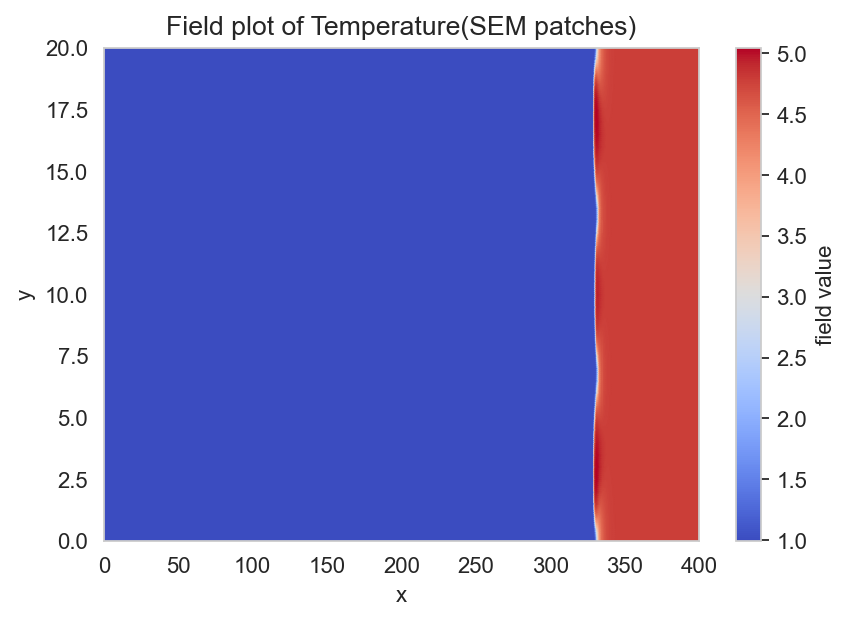

In [50]:
Plot2D.plot_field(ds.msh, ds.T,plot_name="Temperature", mode="sem", cmap="coolwarm")

## Pearson Corellation

In [51]:
Plot2D.print_pearson(front.df, cols=["u","v","T","H2","O2", "Le_def"])

            u    v      T     H2     O2  Le_def
u       1.000 -0.0  0.599 -0.945 -0.418  -0.983
v      -0.000  1.0 -0.000  0.000  0.000  -0.000
T       0.599 -0.0  1.000 -0.791 -0.968  -0.561
H2     -0.945  0.0 -0.791  1.000  0.651   0.943
O2     -0.418  0.0 -0.968  0.651  1.000   0.369
Le_def -0.983 -0.0 -0.561  0.943  0.369   1.000


## Pairplot

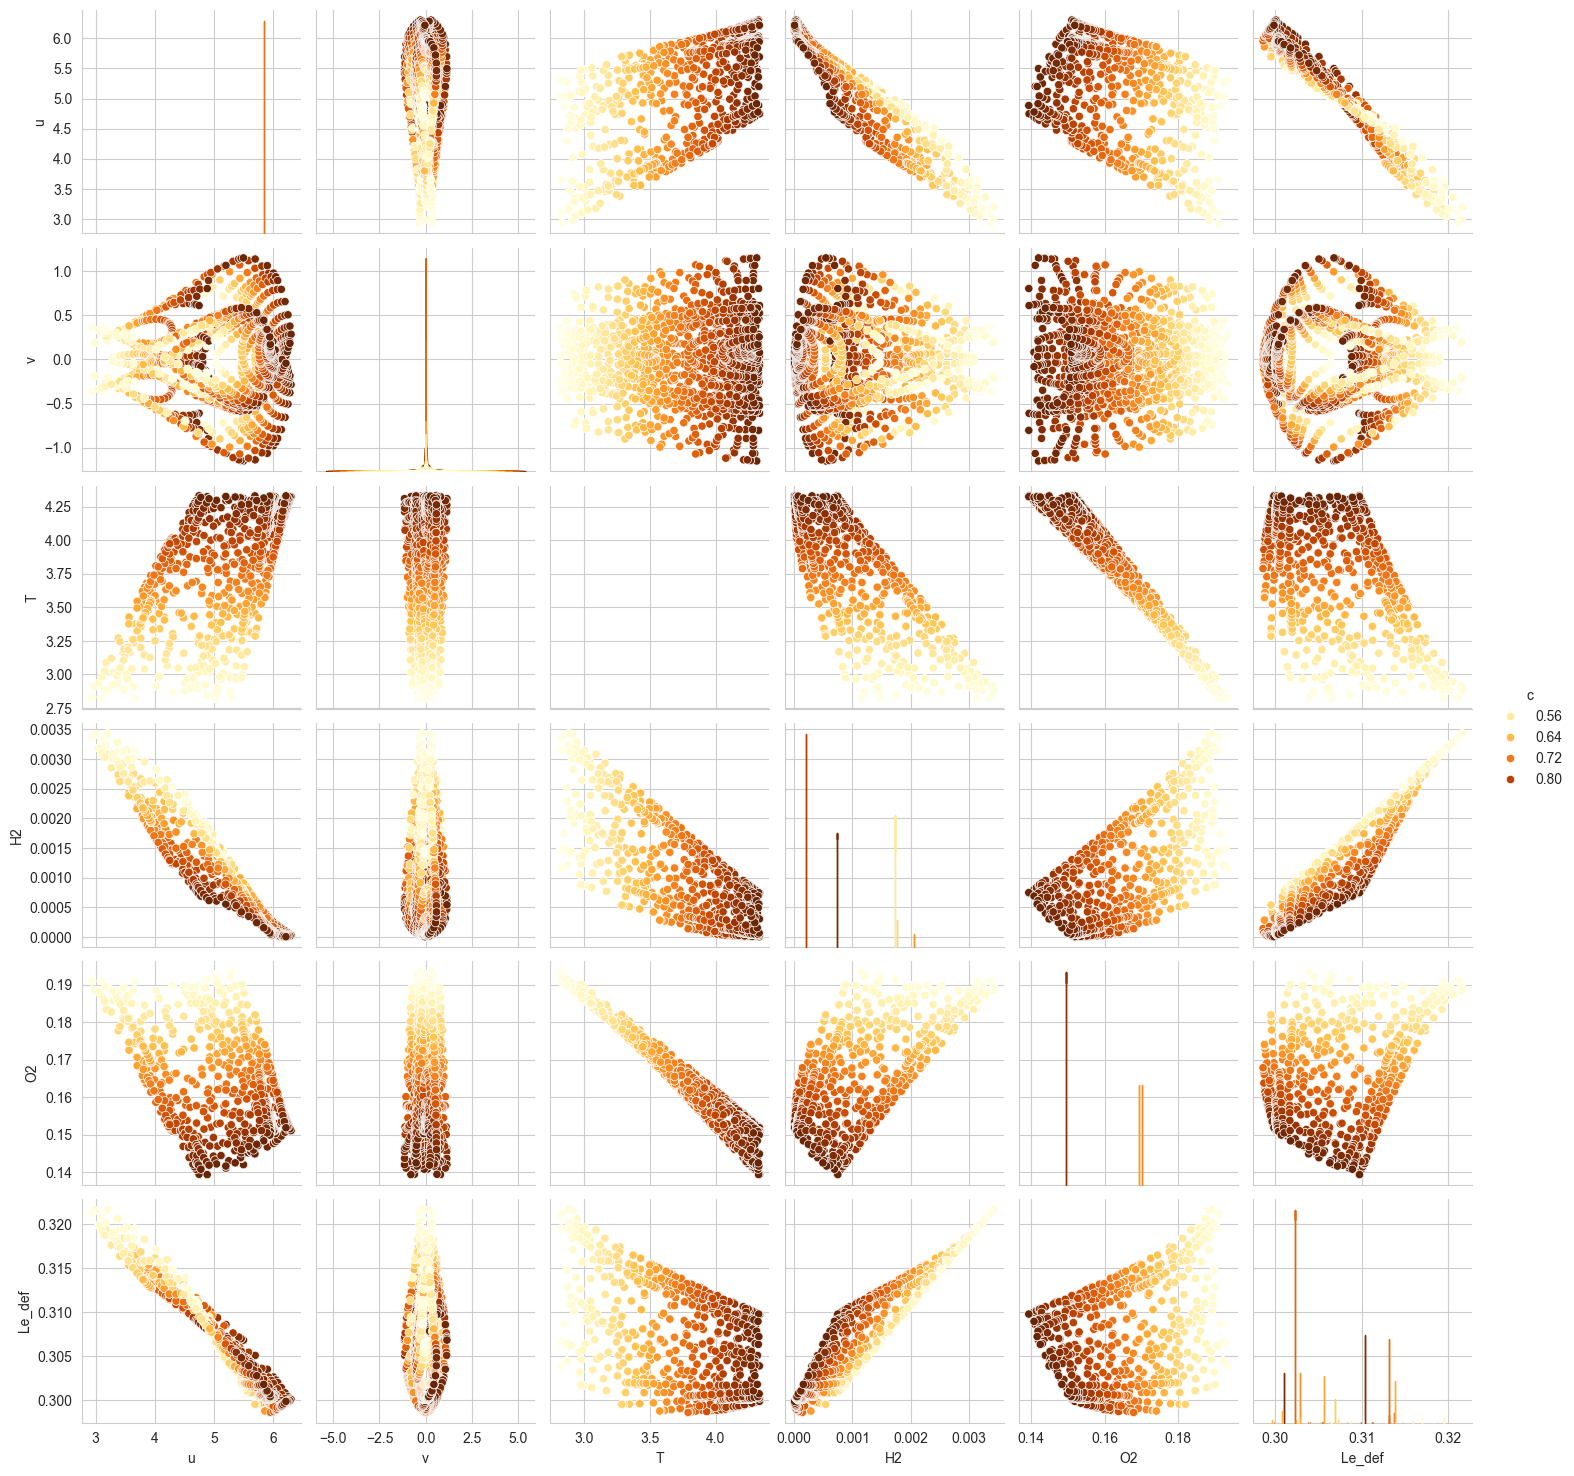

In [52]:
#Plot2D.heat_map(front.df, cols =
#       ["u","v","T","H2","O2", "Le_def"])

cols = ["u","v","T","H2","O2","Le_def"]
sns.pairplot(
    front.df,
    vars=cols,
    hue="c",
    palette="YlOrBr",
    #diag_kind="hist"
    #diag_kws=dict(bins=40, edgecolor=None, alpha=0.8),
);



## NN for velocity prediction

Epoch 1/130
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.1042 - val_loss: 1.4949
Epoch 2/130
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1973 - val_loss: 0.9608
Epoch 3/130
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7084 - val_loss: 0.4963
Epoch 4/130
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4485 - val_loss: 0.3800
Epoch 5/130
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3368 - val_loss: 0.2905
Epoch 6/130
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2648 - val_loss: 0.2737
Epoch 7/130
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2372 - val_loss: 0.2219
Epoch 8/130
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2017 - val_loss: 0.1838
Epoch 9/130
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1726 - val_loss: 0.1691
Epoch 10/130
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1452 - val_loss: 0.1476
Epoch 11/130
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1324 - val_loss: 0.1269
Epoch 12/130
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

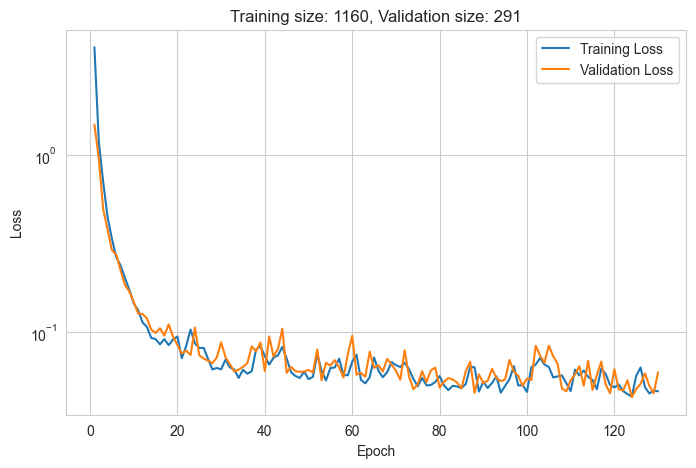

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


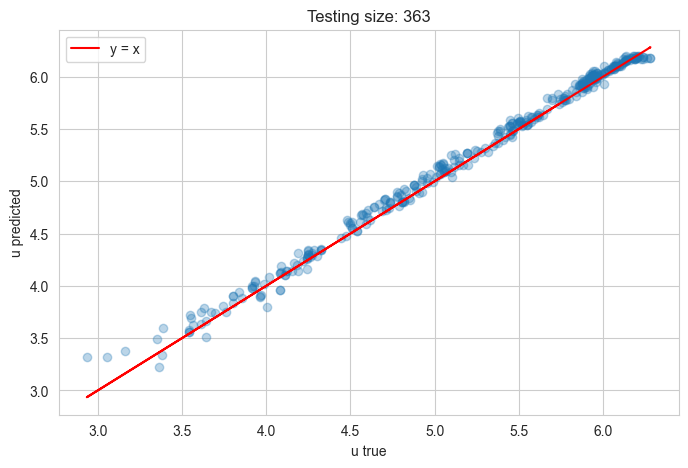

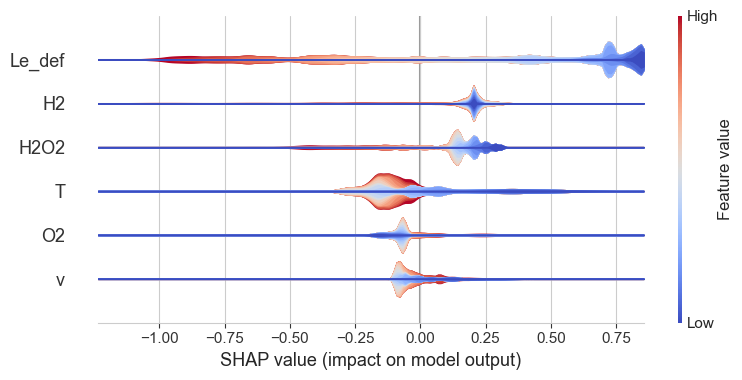

In [53]:
feature_names = ["v","T","H2","O2", "H2O2", "Le_def"]

""""
Old setup:
[ 'curvature' ,'stretch_Law',
        'heat_cond_normal', 'heat_cond_tangential',
        'tangential_strain_Law', 'Le_def', 'vorticity']
"""

ml = MachineLearningModel(features=feature_names, target="u", test_size=0.2, n_epoch= 130)
ml.prepare_data(front.df).build_model().train()
ml.plot_loss()
ml.evaluate()
ml.shap_summary()

